In [1]:
# Load files 
import pandas as pd

orders = pd.read_csv("olist_orders_dataset.csv", 
                     usecols=["order_id","customer_id","order_purchase_timestamp",
                              "order_delivered_customer_date", 'order_approved_at', "order_estimated_delivery_date",
                              "order_status"])


order_items = pd.read_csv("olist_order_items_dataset.csv", 
                          usecols=["order_id","product_id","seller_id","price","freight_value"])


products = pd.read_csv("olist_products_dataset.csv", 
                       usecols=["product_id","product_category_name","product_weight_g",
                                "product_length_cm","product_height_cm","product_width_cm"])


sellers = pd.read_csv("olist_sellers_dataset.csv", 
                      usecols=["seller_id","seller_zip_code_prefix","seller_city","seller_state"])


customers = pd.read_csv("olist_customers_dataset.csv", 
                        usecols=["customer_id","customer_zip_code_prefix","customer_city","customer_state"])

reviews = pd.read_csv('olist_order_reviews_dataset.csv', usecols=['review_score', 'order_id'])


# Set each city to one geolocation coordinate before merging
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
city_geo = (
    geolocation
    .groupby('geolocation_city', as_index=False)
    .agg(geolocation_lat=('geolocation_lat','mean'),
         geolocation_lng=('geolocation_lng','mean'))
    .rename(columns={'geolocation_lat':'city_lat','geolocation_lng':'city_lng'})
)

# Prep two lookup tables: one for customer_city, one for seller_city
city_geo_cust = city_geo.rename(columns={
    'geolocation_city':'customer_city',
    'city_lat':'cust_lat',
    'city_lng':'cust_lng'
})
city_geo_sell = city_geo.rename(columns={
    'geolocation_city':'seller_city',
    'city_lat':'sell_lat',
    'city_lng':'sell_lng'
})

In [2]:
# Filter delivered orders

orders = orders[orders["order_status"] == "delivered"].copy()

In [3]:
# Merge all CSV's

df = orders.merge(order_items, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")
df = df.merge(customers, on="customer_id", how="left")
df = df.merge(reviews, on="order_id", how="left")

df = df.merge(city_geo_cust, on='customer_city', how='left')
df = df.merge(city_geo_sell, on='seller_city',  how='left')

#df.head()

In [4]:
# Calculate distance fucntion

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [5]:
# DT conversion

df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])

df["is_late"] = (df["order_delivered_customer_date"] > df["order_estimated_delivery_date"]).astype(int)

#df["is_late"].value_counts()
#df.head()

In [6]:
# Drop unnecessary columns

df = df.drop(['order_id', 'customer_id', 'order_status', 'product_id', 'seller_zip_code_prefix', 'seller_city', 'customer_zip_code_prefix', 'customer_city'], axis = 1)
#df.head()

In [7]:
# Feature Engineering 

# Introduce volume
df['item_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

# Introduce freight/price ratio
df['freight_to_price'] = df['freight_value'] / df['price']

# Grouping top 10 categories
top_10 = df["product_category_name"].value_counts().head(10).index
df["product_category_name"] = df["product_category_name"].where(
    df["product_category_name"].isin(top_10),
    "other"
)

# Grouping top 5 states
top5_customer = df['customer_state'].value_counts().nlargest(5).index
top5_seller   = df['seller_state'].value_counts().nlargest(5).index
df['customer_state'] = df['customer_state'].where(
    df['customer_state'].isin(top5_customer), 'other'
)

df['seller_state'] = df['seller_state'].where(
    df['seller_state'].isin(top5_seller), 'other'
)

# Day of week
df['order_day_week'] = df['order_purchase_timestamp'].dt.dayofweek

# Week of year
df['order_week_year'] = df['order_purchase_timestamp'].dt.isocalendar().week.astype(int)

# Introduce order at night
df['night_order'] = df["order_purchase_timestamp"].dt.hour.isin([20, 21, 22, 23, 0, 1, 2, 3, 4, 5]).astype(int)

# Introduce order approval lag (in hours)
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['approval_lag_hours'] = ((df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600).round(1)

# Introduce same-state delivery
df["same_state"] = (df["seller_state"] == df["customer_state"]).astype(int)

# Introduce estimated delivery given
df['estimated_delivery_hours'] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.total_seconds() // 3600

# Distance
df['distance_km'] = haversine(
    df['cust_lat'], df['cust_lng'],
    df['sell_lat'], df['sell_lng']
)

# Distance/Delivery Hour ratio
df['distance_hours'] = df['distance_km'] / df['estimated_delivery_hours']

In [8]:
# Drop columns after feature engineering

df = df.drop(['product_width_cm', 'product_length_cm', 'product_height_cm'], axis = 1)
df = df.drop(['order_delivered_customer_date'], axis = 1)
df = df.drop(['order_purchase_timestamp', 'order_estimated_delivery_date', 'seller_id', 'order_approved_at'], axis = 1)
df = df.drop(['sell_lat', 'sell_lng', 'cust_lng', 'cust_lat'], axis = 1)

In [9]:
# One hot encode
columns_to_one_hot_encode = ['product_category_name','seller_state','customer_state']
df = pd.get_dummies(df, columns=columns_to_one_hot_encode, drop_first=False)
print(df.shape)

(110840, 38)


In [10]:
# Train test split

from sklearn.model_selection import train_test_split
X = df.drop(['is_late'], axis=1)
y = df['is_late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print(y.value_counts())

is_late
0    102085
1      8755
Name: count, dtype: int64


In [11]:
# XGBoost Baseline model

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

baseline_model = XGBClassifier(
    scale_pos_weight=11.6,   # 👈 imbalance handling
    random_state=21
)
baseline_model.fit(X_train,y_train, verbose=1)
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


# Store results across models
results = {}
results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}

Accuracy: 0.8670155178635871
F1: 0.4558877814691768
ROC AUC: 0.8737248450267037
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     20434
           1       0.34      0.71      0.46      1734

    accuracy                           0.87     22168
   macro avg       0.65      0.80      0.69     22168
weighted avg       0.92      0.87      0.89     22168



C:\Users\mtaah\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


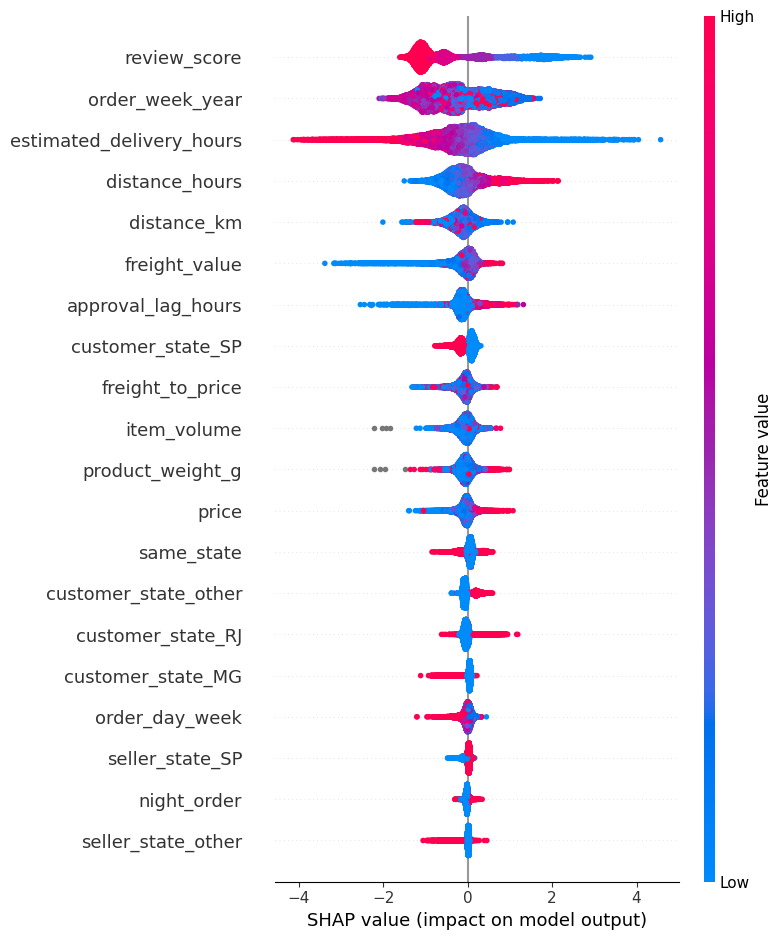

In [21]:
#Feature Importance check to evaluate feature engineering

import shap

# for tree models (RF/XGB)
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_values, X_test)

In [13]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    class_weight="balanced",
    n_jobs=-1,
    random_state=21
)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)   # lower threshold to boost recall (threshold tuning)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}

Accuracy: 0.9271021291952364
F1: 0.5465768799102132
ROC AUC: 0.8885782894127084
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     20434
           1       0.53      0.56      0.55      1734

    accuracy                           0.93     22168
   macro avg       0.75      0.76      0.75     22168
weighted avg       0.93      0.93      0.93     22168



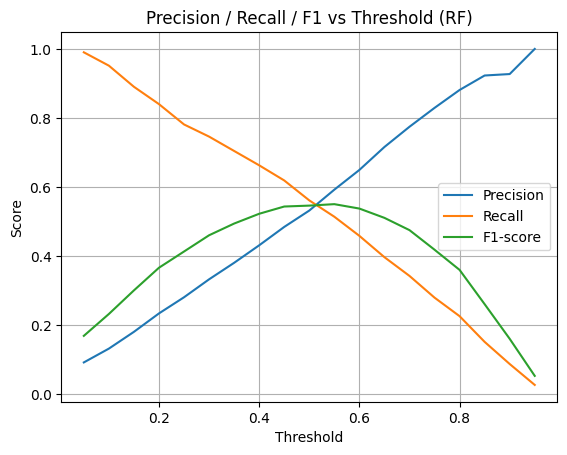

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.05, 0.95, 19)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold (RF)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# # Cross Validation

# from sklearn.model_selection import StratifiedKFold, cross_val_score
# import numpy as np

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# scores = cross_val_score(
#     clf,
#     X, y,
#     cv=cv,
#     scoring="f1"
# )

# print("F1 mean:", np.mean(scores))
# print("F1 std:", np.std(scores))

#F1 mean: 0.43077018097704106
#F1 std: 0.01434759129824481

In [16]:
# Hyperparameter tuning

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [1, 2, 5]
# }

# grid = GridSearchCV(
#     RandomForestClassifier(class_weight="balanced", random_state=21, n_jobs=-1),
#     param_grid,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# print("Best params:", grid.best_params_)
# print("Best score:", grid.best_score_)

# Best params: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 300}
# Best score: 0.4033718414064435

In [17]:
# LGM Classifier 

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# model
lgbm = LGBMClassifier(
    n_estimators=300,
    class_weight="balanced", # handle imbalance
    random_state=21,
    n_jobs=-1
)

# fit
lgbm.fit(X_train, y_train)

# predict
y_proba = lgbm.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.74).astype(int)   # adjust threshold

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

results['LGM Classifer'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}

[LightGBM] [Info] Number of positive: 7021, number of negative: 81651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 88672, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy: 0.9225009022013714
F1: 0.5277625068719076
ROC AUC: 0.8824392459860925
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     20434
           1       0.50      0.55      0.53      1734

    accuracy                           0.92     22168
   macro avg       0.73      0.75      0.74     22168
weighted avg       0.93      0.92      0.92     22168



In [18]:
# catboost Classifier 

from catboost import CatBoostClassifier

# model
cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    class_weights=[1, 12],   # ratio ~1:12 for imbalance
    random_seed=21,
    verbose=100
)

# fit (if you have raw categoricals, pass cat_features=[list of column indices])
cat.fit(X_train, y_train)

# predict
y_proba = cat.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.65).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

results['catboost'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}

0:	learn: 0.6761994	total: 144ms	remaining: 43s
100:	learn: 0.4614923	total: 2.36s	remaining: 4.65s
200:	learn: 0.4386169	total: 4.31s	remaining: 2.12s
299:	learn: 0.4186106	total: 6.13s	remaining: 0us
Accuracy: 0.8825784915193071
F1: 0.4673623900143237
ROC AUC: 0.8738459624532874
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     20434
           1       0.36      0.66      0.47      1734

    accuracy                           0.88     22168
   macro avg       0.67      0.78      0.70     22168
weighted avg       0.92      0.88      0.90     22168



               Accuracy        F1
XGBoost        0.867016  0.455888
Random Forest  0.927102  0.546577
LGM Classifer  0.922501  0.527763
catboost       0.882578  0.467362


<Axes: title={'center': 'Model Comparison'}>

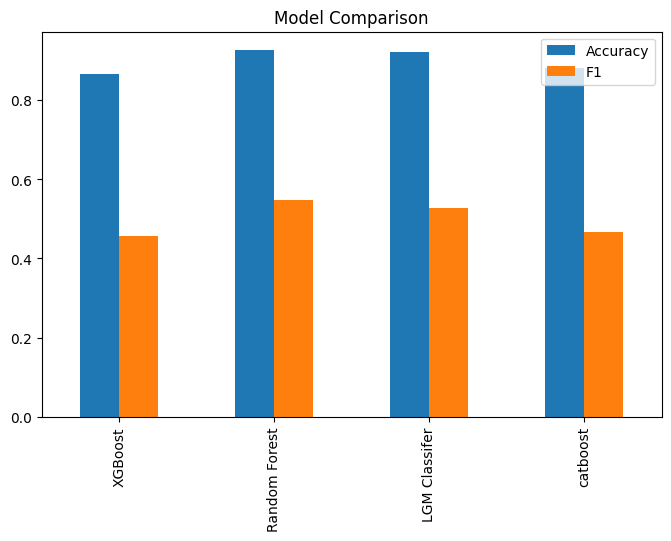

In [19]:
# Plot final model comparison

results_df = pd.DataFrame(results).T
print(results_df)
results_df.plot(kind='bar', figsize=(8,5), title="Model Comparison")